In [159]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from tqdm import tqdm
from scipy import ndimage

In [2]:
import torch.nn.functional as F
import torch as tc

In [3]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [160]:
def rotation(orig, gts):
    ks=[90,180,270]
    rotated=[ndimage.rotate(img,k) for img in orig for k in ks]
    gt_rotated=[ndimage.rotate(gt_img,k) for gt_img in gts for k in ks]
    orig=orig+rotated
    gts=gts+gt_rotated
    #print(len(orig))
    #print(len(gts))
    return orig,gts

In [ ]:
? os.listdir

In [110]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
N = min(90, len(files)) # Load maximum 90 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(N)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(N)]
print(files[0])

#n = 85 # Only use 85 images for training

Loading 85 images
satImage_052.png
Loading 85 images
satImage_052.png


In [161]:
# augment the dataset adding rotated images
imgs, gt_imgs = rotation(imgs, gt_imgs)
print('Total number of imgages: '+str(len(imgs)))

Total number of imgages: 360


In [163]:
n=90*3
N=len(imgs)
train_imgs=imgs[0:n]
train_mask=gt_imgs[0:n]
test_imgs=imgs[n:N]
test_mask = gt_imgs[n:N]


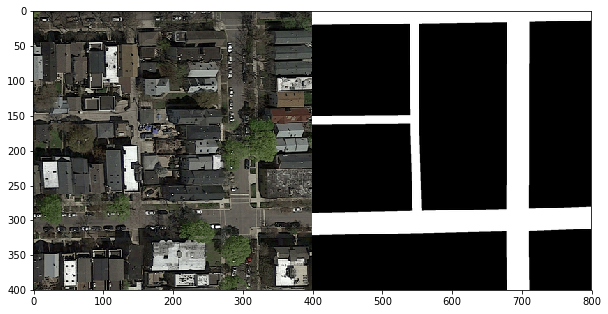

In [164]:
temp=concatenate_images(train_imgs[3], train_mask[3])
plt.figure(figsize=(10, 10))
plt.imshow(temp)

In [97]:
# create a neural network (very simple model)
class Net(tc.nn.Module):
    def __init__(self,dropout,features=3):
        super(Net,self).__init__()
        self.is_training=False
        self.conv1=tc.nn.Conv2d(features,8,kernel_size=(5,5))
        self.conv2=tc.nn.Conv2d(8,8,kernel_size=(3,3))
        self.drop=tc.nn.Dropout(dropout)
        # Net created for input_files 16*16
        self.fc1=tc.nn.Linear(100*8,256)
        self.fc2=tc.nn.Linear(256,1)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,100*8)
        if self.is_training:
            x = self.drop(x)
        x = F.relu(self.fc1(x))
        if self.is_training:
            x = self.drop(x)
        x= tc.sigmoid(self.fc2(x))
        #x = self.fc2(x)
        return x

In [12]:
? tc.nn.Dropout

In [ ]:
print(len(train_mask))

In [14]:
def from_mask_to_vector(mask_imgs,threshold):
    '''the method takes as input a list of mask and return a vector where the ith component
    is 1 if the majority of the ith mask list element is 1'''
    mask_imgs=np.array(mask_imgs).reshape(-1,16,16)
    vector=mask_imgs.sum(axis=(1,2))
    vector=vector[:] > mask_imgs.shape[1]*mask_imgs.shape[2]*threshold
    return vector
    

In [30]:
print(len(test_imgs),N-n)

5 5


In [165]:
# prepare input data 
w=16
h=16
train_sub_images=[img_crop(train_imgs[i], w, h) for i in range(n)]
train_mask_label=[img_crop(train_mask[i],w,h) for i in range(n)]
train_mask_label=from_mask_to_vector(train_mask_label,0.3)
test_sub_images=[img_crop(test_imgs[i], w, h) for i in range(N-n)]
#test_mask_label=[img_crop(train_mask[n+i],w,h) for i in range(n)]
#test_mask_label=from_mask_to_vector(test_mask_label)


In [166]:
print((1*train_mask_label).sum()/len(train_mask_label))

0.24573629629629629


In [167]:
print(len(train_sub_images[0]))

625


In [34]:
def transform_subIMG_to_Tensor(sub_img_list):
    '''Transform a list of list of sub images into a Tensor,
    where the first index point to different sub images'''
    N0= len(sub_img_list)
    N1= len(sub_img_list[0])
    N=N0*N1
    x,y,channels=sub_img_list[0][0].shape
    #print(sub_img_list[6][600])
    tensor=tc.Tensor(N,channels,x,y)
    for j,image in enumerate(sub_img_list):
        for k,sub_image in enumerate(image):
            tensor[j*N1+k,:,:,:]=tc.FloatTensor(np.array([sub_image[:,:,i] for i in range(sub_image.shape[2])]))
    #print(tensor[6*625+600])
    return tensor

In [168]:
train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
test_sub_images = transform_subIMG_to_Tensor(test_sub_images)

In [98]:
# train the net
def train_model_Adam( model, train_data, label, threshold=0.01, max_epochs, lr, mini_batch_size):
    '''train the Neural Net using Adam as optimizer and an MSE loss'''
    #optimizer=tc.optim.SGD(model.parameters(),lr)
    optimizer=tc.optim.Adam(model.parameters(),lr)
    criterion= tc.nn.MSELoss()
    training_errors=[]
    
    
    for epoch in tqdm(range(max_epochs)):
        model.is_training=True
        for i in range(0,train_data.size(0),mini_batch_size):
            output= model(train_data.narrow(0,i,mini_batch_size))
            #print(output,tc.LongTensor(np.array([1*label[i:i+mini_batch_size]]).reshape(-1,1)))
            loss= criterion(output,tc.FloatTensor(np.array([1*label[i:i+mini_batch_size]]).reshape(-1,1)))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        # compute training error
        model.is_training=False
        test = model(train_data)
        prediction= test[:]>0.5
        
        prediction= 1*(prediction.numpy()[:] != label.reshape(-1,1)[:])
        
        training_error = np.sum(prediction)/len(prediction)
        training_errors.append(training_error*100)
        if training_error< threshold:
            break
        
    
    plt.figure()
    plt.plot(np.arange(epoch)+1,training_errors)
    plt.xlabel('epoch')
    plt.ylabel('error [%]')
    plt.show()
        
        
    

In [169]:
# normalize data
mean = train_sub_images.mean()
std = train_sub_images.std()
train_sub_images = (train_sub_images-mean)/std
train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
#print(train_sub_images[-1]-train_sub_images[-2])
for l in range(n):
    new_indices= np.random.permutation(len(train_mask_label))
    train_sub_images=train_sub_images[new_indices]
    train_mask_label=train_mask_label[new_indices]
#print(train_sub_images[0]-train_sub_images[1])
#train_sub_images.requires_grad_(True)

In [38]:
def reduce_dataset(dataset,label):
    new_dataset=[]
    new_label=[]
    nb_zeros=0
    ones_positions=np.where(label)[0]
    for pos in ones_positions:
        new_dataset.append(dataset.narrow(0,int(pos),1))
        new_label.append(1)
        
    while nb_zeros < len(ones_positions):
        j= np.random.randint(0,dataset.size(0))
        if label[j]==0:
            #print(j)
            new_dataset.append(dataset.narrow(0,j,1))
            new_label.append(0)
            nb_zeros+=1
    new_dataset=tc.cat(new_dataset,dim=0)
    new_label=np.array(new_label)
    return new_dataset,new_label

In [ ]:
 ? tc.Tensor.narrow

In [ ]:
print(train_mask_label.sum()/len(train_mask_label))

100%|██████████| 15/15 [1:44:23<00:00, 417.54s/it]


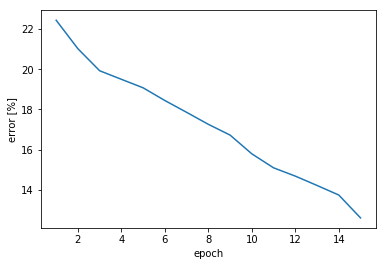

In [170]:
model = Net(0)
lr=1e-4
max_epochs=15
mini_batch_size=1

train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)

In [ ]:
print(tc.__version__)

In [ ]:
? tc.mean

In [44]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [45]:
def calcul_F1(mask, prediction):   
    '''compute the F1 error'''
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if (round(mask[i,j])==0) & (prediction[i,j]==0):
                TN = TN + 1
            elif (round(mask[i,j])==1) & (prediction[i,j]==0):
                FN = FN + 1   
            elif (round(mask[i,j])==1) & (prediction[i,j]==1):
                TP = TP + 1  
            else:
                FP = FP + 1
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1_score = 2*precision*recall / (precision+recall) 
    return F1_score

In [50]:
N1=625

In [176]:
# print the result on a single image
#N1=int(train_sub_images.size(0)/n)
image_test= test_sub_images.narrow(0,43*N1,N1)
image_test=(image_test-mean)/std
mask_array=model(image_test)
#print(mask_array.max())
mask_list=mask_array[:]>0.5
mask_test = label_to_img(400, 400, 16, 16, mask_list)

In [177]:
# compute F1 score
mask=gt_imgs[n]
#print(mask.sum())
print(calcul_F1(mask, mask_test))

0.24008245255946487


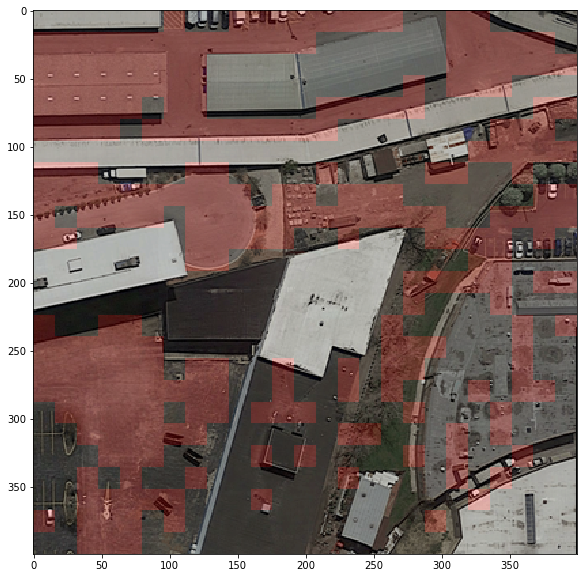

In [180]:
# overlap images

print_img = make_img_overlay(imgs[n+43], mask_test)
#print_img = make_img_overlay(imgs[n+43], gt_imgs[n+43])
plt.figure(figsize=(10, 10))
plt.imshow(print_img)

In [130]:
def compute_test_error(test_dataset, test_label, nb_patches, model):
    ''' compute the F1 error made during road segmentation. 
    Exemple: for a 16*16 patch we have that nb_patches=625'''
    model.is_train=False
    mean=test_dataset.mean()
    std= test_dataset.std()
    test_dataset = (test_dataset-mean)/std
    test_output = model(test_dataset)
    w = int(400/np.sqrt(nb_patches))
    F1_error=np.zeros(int(test_dataset.size(0)/nb_patches))
    for i in range(int(test_dataset.size(0)/nb_patches)):
        mask = test_output.narrow(0,i*nb_patches, nb_patches)
        mask = mask.detach().numpy()[:]>0.5
        mask = label_to_img(400, 400, w, w, mask)
        F1_error[i] = calcul_F1(test_label[i], mask)
    plt.figure()
    plt.plot(np.arange(int(test_dataset.size(0)/nb_patches))+1,F1_error)
    plt.xlabel('image')
    plt.ylabel('F1_error')
    F1_mean= np.mean(F1_error)
    return F1_mean
    

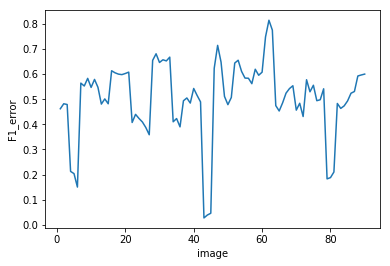

In [174]:
F1=compute_test_error(test_sub_images, test_mask, 625, model)

In [175]:
print(F1)

0.5048651551462583
